**Importing dependencies**

In [1]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Unzip the File

In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/asl_alphabet_train.zip"  # adjust if it's in a subfolder
extract_path = "/content/asl_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Set Device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


. Data Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Update the path as needed
train_dataset = datasets.ImageFolder(root="/content/asl_data/asl_alphabet_train", transform=transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

classes = train_dataset.dataset.classes


Model Architecture

In [7]:
class ASLClassifier(nn.Module):
    def __init__(self):
        super(ASLClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512), nn.ReLU(),
            nn.Linear(512, len(classes))
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = ASLClassifier().to(device)


Training Setup

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training Loop

In [9]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 560.4134
Epoch 2/10, Loss: 55.5019
Epoch 3/10, Loss: 35.6028
Epoch 4/10, Loss: 26.9572
Epoch 5/10, Loss: 19.6837
Epoch 6/10, Loss: 19.8991
Epoch 7/10, Loss: 15.6059
Epoch 8/10, Loss: 15.4714
Epoch 9/10, Loss: 14.8224
Epoch 10/10, Loss: 6.1710


Evaluation


Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       580
           B       1.00      1.00      1.00       604
           C       1.00      1.00      1.00       550
           D       1.00      1.00      1.00       637
           E       1.00      1.00      1.00       615
           F       1.00      1.00      1.00       622
           G       1.00      0.99      1.00       584
           H       1.00      1.00      1.00       588
           I       1.00      1.00      1.00       590
           J       1.00      1.00      1.00       601
           K       1.00      0.94      0.97       590
           L       1.00      1.00      1.00       606
           M       1.00      1.00      1.00       579
           N       0.99      1.00      1.00       624
           O       1.00      1.00      1.00       611
           P       1.00      1.00      1.00       594
           Q       0.99      1.00      0.99       589
   

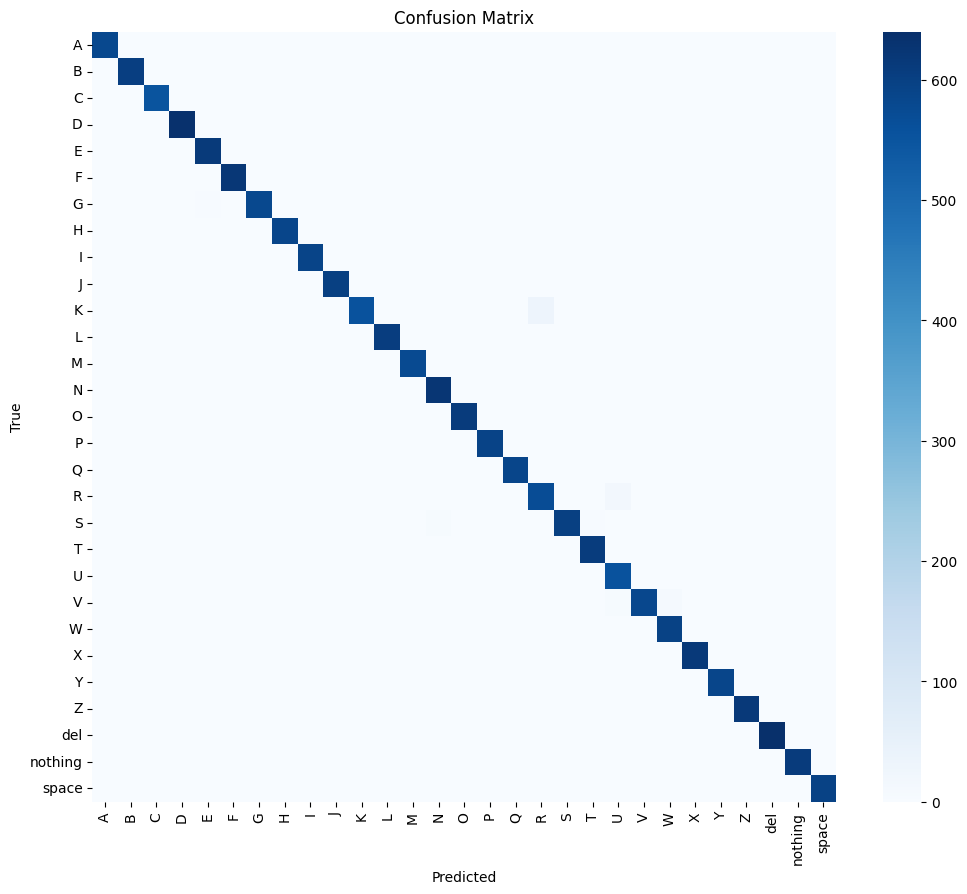

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

#  Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Individual Metric Scores
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

#  Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=False, cmap='Blues', fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
